# L1 - ImageNet pretrained ResNets with STONEFLY9 dataset

In this notebook a ImageNet pretrained ResNet is trained on the [STONEFLY9 dataset](http://web.engr.oregonstate.edu/~tgd/bugid/stonefly9/).<br>

**Accuracy results:**<br>
ResNet34: 0.995037<br>
ResNet50: 0.998677<br>
([Literature benchmark](http://web.engr.oregonstate.edu/~tgd/publications/jnabs-2010-automated.pdf): 0.964)

## Notebook setup

In [1]:
# notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai library
from fastai import *
from fastai.vision import *

## Data setup

In [3]:
# set path to data directory
path = Path('/home/paperspace/fastai/data/stonefly')

### Download data

In [6]:
# get low-resolution STONEFLY9 dataset
!wget http://web.engr.oregonstate.edu/~tgd/bugid/stonefly9/JPEG_lowRes.tar.gz -P /home/paperspace/fastai/data/stonefly/

--2018-10-26 13:27:35--  http://web.engr.oregonstate.edu/~tgd/bugid/stonefly9/JPEG_lowRes.tar.gz
Resolving web.engr.oregonstate.edu (web.engr.oregonstate.edu)... 128.193.40.12
Connecting to web.engr.oregonstate.edu (web.engr.oregonstate.edu)|128.193.40.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 526140670 (502M) [application/x-gzip]
Saving to: ‘/home/paperspace/fastai/data/stonefly/JPEG_lowRes.tar.gz’

JPEG_lowRes.tar.gz  100%[===================>] 501.77M  13.7MB/s    in 42s     

2018-10-26 13:28:18 (11.9 MB/s) - ‘/home/paperspace/fastai/data/stonefly/JPEG_lowRes.tar.gz’ saved [526140670/526140670]



In [1]:
# unzip JPEG_lowRes.tar.gz file into stonefly directory
!tar -xvzf /home/paperspace/fastai/data/stonefly/JPEG_lowRes.tar.gz -C /home/paperspace/fastai/data/stonefly/

In [31]:
# get total jpg file count in dataset directory
!ls -R /home/paperspace/fastai/data/stonefly/ | grep -c .jpg

3845


In [24]:
# export a list of all the image paths into a text-file
!ls -d -1 /home/paperspace/fastai/data/stonefly/**/*/*/* > /home/paperspace/fastai/data/stonefly/files.txt

### Dataframe setup

In [4]:
# read in text file with a list of all the files
df = pd.read_csv(path/'files.txt', sep=' ', header=None, names=['imgurl'])

In [5]:
# test of string manipulation to get the data class
#('/home/paperspace/fastai/data/stonefly/JPEG_lowRes/cal/set0/Cal_10-specimen-i001-s125.jpg').split('/', 6)[-1] # split only 6 times

In [6]:
# define string manipulation lambda function to get path after the defined path variable
f = lambda x: x.split('/', 6)[-1]
df['imgurl'] = df['imgurl'].apply(f)

In [7]:
# test of string manipulation to get the data class
#('/home/paperspace/fastai/data/stonefly/JPEG_lowRes/cal/set0/Cal_10-specimen-i001-s125.jpg').split('/')[-3]

In [8]:
# define string manipulation lambda function to get data class
f = lambda x: x.split('/')[-3]
df['class'] = df['imgurl'].apply(f)

In [9]:
# verify dataframe
df.head()

,imgurl,class
0,JPEG_lowRes/cal/set0/Cal_10-specimen-i001-s125...,cal
1,JPEG_lowRes/cal/set0/Cal_10-specimen-i002-s125...,cal
2,JPEG_lowRes/cal/set0/Cal_10-specimen-i003-s125...,cal
3,JPEG_lowRes/cal/set0/Cal_10-specimen-i004-s125...,cal
4,JPEG_lowRes/cal/set0/Cal_10-specimen-i005-s125...,cal


In [10]:
df.tail()

,imgurl,class
3840,JPEG_lowRes/zap/set2/Zap_99-specimen-i001-s125...,zap
3841,JPEG_lowRes/zap/set2/Zap_99-specimen-i002-s125...,zap
3842,JPEG_lowRes/zap/set2/Zap_99-specimen-i003-s125...,zap
3843,JPEG_lowRes/zap/set2/Zap_99-specimen-i004-s125...,zap
3844,JPEG_lowRes/zap/set2/Zap_99-specimen-i005-s125...,zap


### ImageDataBunch setup

In [11]:
size = 224 # image size used for training (Note: is only applied when ds_tfms are set)
bs = 64 # batchsize for training

In [12]:
data = ImageDataBunch.from_df(path, df, ds_tfms=get_transforms(), size=size, bs=bs)

In [13]:
# normalize data with the imagent_stats
data.normalize(imagenet_stats)

In [14]:
# verify ImageDataBunch setup
data.path

PosixPath('/home/paperspace/fastai/data/stonefly')

In [15]:
# check if dataset classes equal datatset class count
len(data.train_ds.classes), data.train_ds.c

(9, 9)

### Data exploration

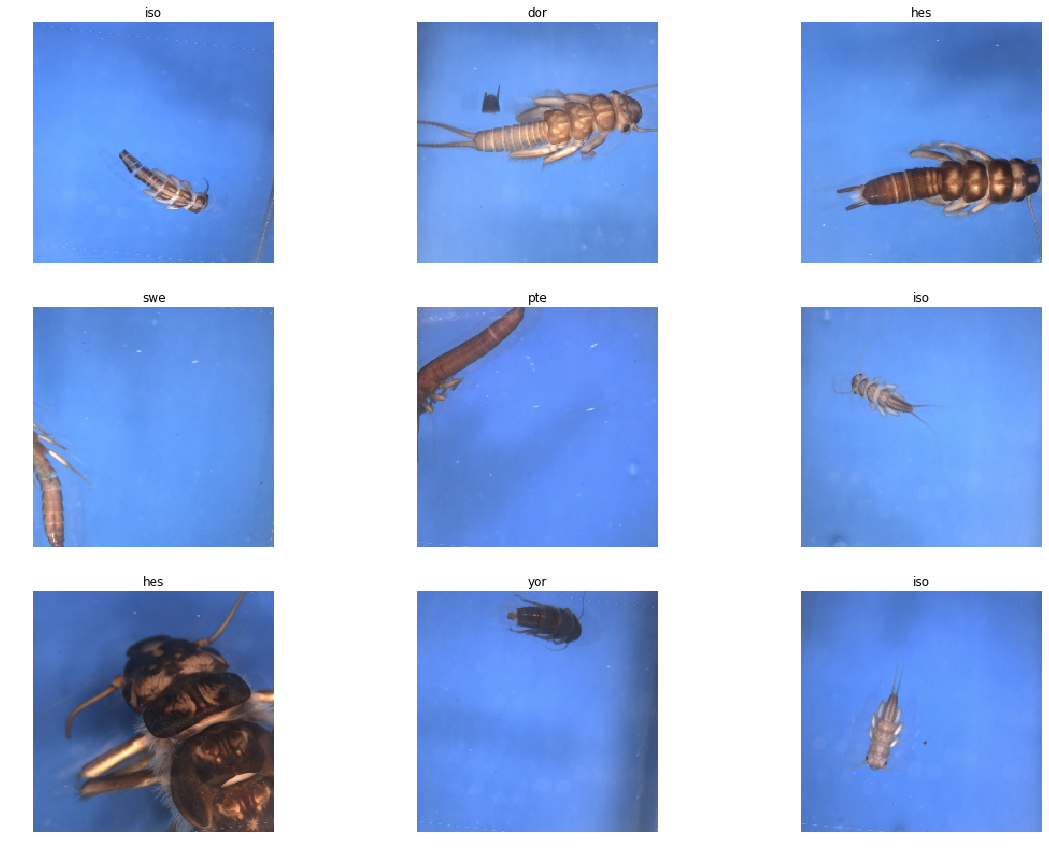

In [16]:
data.show_batch(rows=3, figsize=(17,12))

## ResNet34

### Learner setup

In [88]:
learn = ConvLearner(data, models.resnet34, metrics=accuracy)

### Stage 1 - Training

In [124]:
!gpustat

psbtmxtmo  Fri Oct 26 14:53:00 2018
[0] Quadro P4000     | 68'C,   0 % |  7270 /  8119 MB | paperspace(4445M) paperspace(2815M)


In [89]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


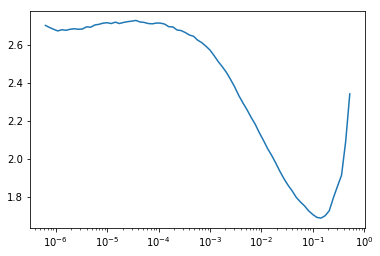

In [90]:
learn.recorder.plot()

In [92]:
lr = 1e-2

In [96]:
!gpustat

psbtmxtmo  Fri Oct 26 14:19:21 2018
[0] Quadro P4000     | 38'C,   0 % |  4778 /  8119 MB | paperspace(3939M) paperspace(829M)


In [93]:
# train for 1 epoch to get a feeling for the losses and the accuracy
learn.fit_one_cycle(1, max_lr=lr)

Total time: 01:20
epoch  train_loss  valid_loss  accuracy
1      0.641965    0.198866    0.934243  (01:20)



In [97]:
# additional training
learn.fit_one_cycle(8, max_lr=lr)

Total time: 04:57
epoch  train_loss  valid_loss  accuracy
1      0.261692    0.158409    0.950372  (00:36)
2      0.247143    0.153286    0.941687  (00:37)
3      0.269598    0.701948    0.826303  (00:37)
4      0.260106    0.087266    0.972705  (00:36)
5      0.198019    0.078771    0.970223  (00:36)
6      0.138786    0.042115    0.987593  (00:37)
7      0.098745    0.034911    0.987593  (00:37)
8      0.084334    0.031462    0.987593  (00:37)



In [103]:
#learn.recorder.plot_losses()

In [99]:
# additional training because training loss is still higher than the validation loss
learn.fit_one_cycle(8, max_lr=lr)

Total time: 05:23
epoch  train_loss  valid_loss  accuracy
1      0.081792    0.084624    0.973945  (00:40)
2      0.113463    0.444896    0.882134  (00:40)
3      0.187874    1.631831    0.713400  (00:39)
4      0.189726    0.250692    0.933002  (00:41)
5      0.156558    0.072536    0.970223  (00:41)
6      0.128971    0.051730    0.981390  (00:39)
7      0.095782    0.022439    0.991315  (00:40)
8      0.063661    0.020630    0.991315  (00:40)



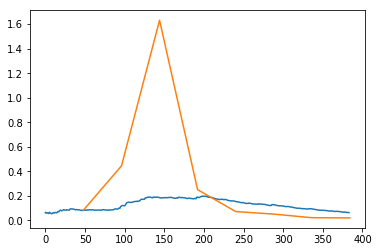

In [100]:
learn.recorder.plot_losses()

In [101]:
learn.fit_one_cycle(8) # without max lr

Total time: 04:57
epoch  train_loss  valid_loss  accuracy
1      0.047429    0.020246    0.992556  (00:40)
2      0.042277    0.019560    0.992556  (00:38)
3      0.049151    0.029027    0.990074  (00:37)
4      0.040677    0.026042    0.991315  (00:37)
5      0.050364    0.032707    0.987593  (00:37)
6      0.046110    0.019432    0.992556  (00:37)
7      0.047327    0.016803    0.993797  (00:35)
8      0.040084    0.016863    0.993797  (00:33)



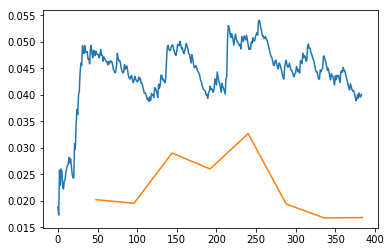

In [102]:
learn.recorder.plot_losses()

In [104]:
learn.fit_one_cycle(8) # without max lr

Total time: 04:35
epoch  train_loss  valid_loss  accuracy
1      0.029799    0.017245    0.993797  (00:36)
2      0.036762    0.029827    0.988834  (00:33)
3      0.042091    0.031756    0.987593  (00:35)
4      0.036180    0.015531    0.996278  (00:34)
5      0.042667    0.016957    0.996278  (00:33)
6      0.038740    0.015304    0.996278  (00:33)
7      0.031231    0.014023    0.996278  (00:35)
8      0.027470    0.013647    0.996278  (00:32)



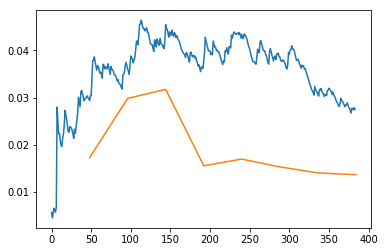

In [105]:
learn.recorder.plot_losses()

In [139]:
learn.save('stonefly_resnet34_stage_1')

### Stage 2

In [126]:
!gpustat

psbtmxtmo  Fri Oct 26 14:55:02 2018
[0] Quadro P4000     | 69'C,  98 % |  7270 /  8119 MB | paperspace(4445M) paperspace(2815M)


In [140]:
learn.load('stonefly_resnet34_stage_1')

In [128]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


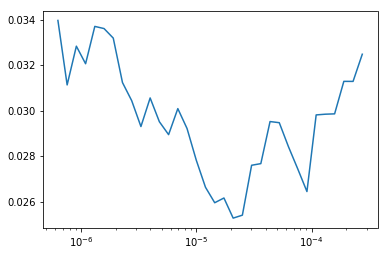

In [129]:
learn.recorder.plot()

In [130]:
lr=1e-5

In [131]:
learn.unfreeze()

In [132]:
learn.fit_one_cycle(1, max_lr=lr)

Total time: 01:01
epoch  train_loss  valid_loss  accuracy
1      0.041091    0.022515    0.992556  (01:01)



In [133]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 02:23
epoch  train_loss  valid_loss  accuracy
1      0.022157    0.021901    0.991315  (00:57)
2      0.027216    0.027297    0.990074  (00:46)
3      0.024780    0.029803    0.987593  (00:39)



In [134]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 01:51
epoch  train_loss  valid_loss  accuracy
1      0.031255    0.027060    0.988834  (00:36)
2      0.025145    0.017536    0.995037  (00:37)
3      0.024659    0.020058    0.990074  (00:36)



In [136]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 02:02
epoch  train_loss  valid_loss  accuracy
1      0.024430    0.017906    0.993797  (00:34)
2      0.028144    0.020577    0.995037  (00:36)
3      0.032005    0.016643    0.995037  (00:52)



In [137]:
learn.save('stonefly_resnet34_stage_2')

## ResNet50

### Learner setup

In [16]:
!gpustat

psbtmxtmo  Sat Oct 27 01:43:46 2018
[0] Quadro P4000     | 44'C,   0 % |   563 /  8119 MB | paperspace(553M)


In [17]:
learn = ConvLearner(data, models.resnet50, metrics=accuracy)

### Stage 1 - Training

In [19]:
!gpustat

psbtmxtmo  Sat Oct 27 01:39:06 2018
[0] Quadro P4000     | 39'C,   0 % |   617 /  8119 MB | paperspace(607M)


In [20]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


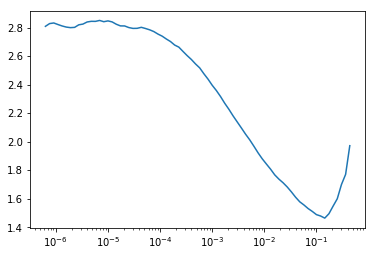

In [21]:
learn.recorder.plot()

In [22]:
lr=1e-2

In [23]:
learn.fit_one_cycle(1, max_lr=lr)

Total time: 00:38
epoch  train_loss  valid_loss  accuracy
1      0.527495    0.201580    0.933060  (00:38)



In [24]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 01:48
epoch  train_loss  valid_loss  accuracy
1      0.286391    0.708199    0.790984  (00:35)
2      0.271295    0.474193    0.875683  (00:35)
3      0.172210    0.026287    0.990437  (00:36)



In [25]:
learn.fit_one_cycle(8, max_lr=lr)

Total time: 04:53
epoch  train_loss  valid_loss  accuracy
1      0.094921    0.118555    0.957650  (00:36)
2      0.174625    0.628990    0.833333  (00:36)
3      0.209188    0.422344    0.862022  (00:35)
4      0.217224    0.327415    0.896175  (00:35)
5      0.153046    0.256900    0.912568  (00:36)
6      0.102339    0.007763    0.998634  (00:36)
7      0.061359    0.006624    0.997268  (00:37)
8      0.046177    0.005507    0.997268  (00:38)



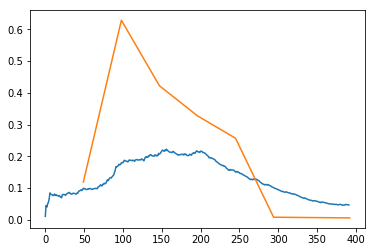

In [26]:
learn.recorder.plot_losses()

In [27]:
learn.fit_one_cycle(8, max_lr=lr)

Total time: 04:52
epoch  train_loss  valid_loss  accuracy
1      0.054960    0.032964    0.984973  (00:36)
2      0.074649    0.142625    0.960383  (00:36)
3      0.167328    0.260295    0.924863  (00:36)
4      0.142912    0.086757    0.972678  (00:35)
5      0.106656    0.088524    0.961749  (00:36)
6      0.070898    0.013499    0.995902  (00:36)
7      0.052464    0.006312    0.998634  (00:35)
8      0.033993    0.006365    0.998634  (00:38)



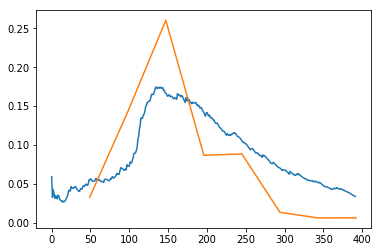

In [28]:
learn.recorder.plot_losses()

In [30]:
learn.save('stonefly_resnet50_stage_1')

### Stage 1 - Interpretation

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

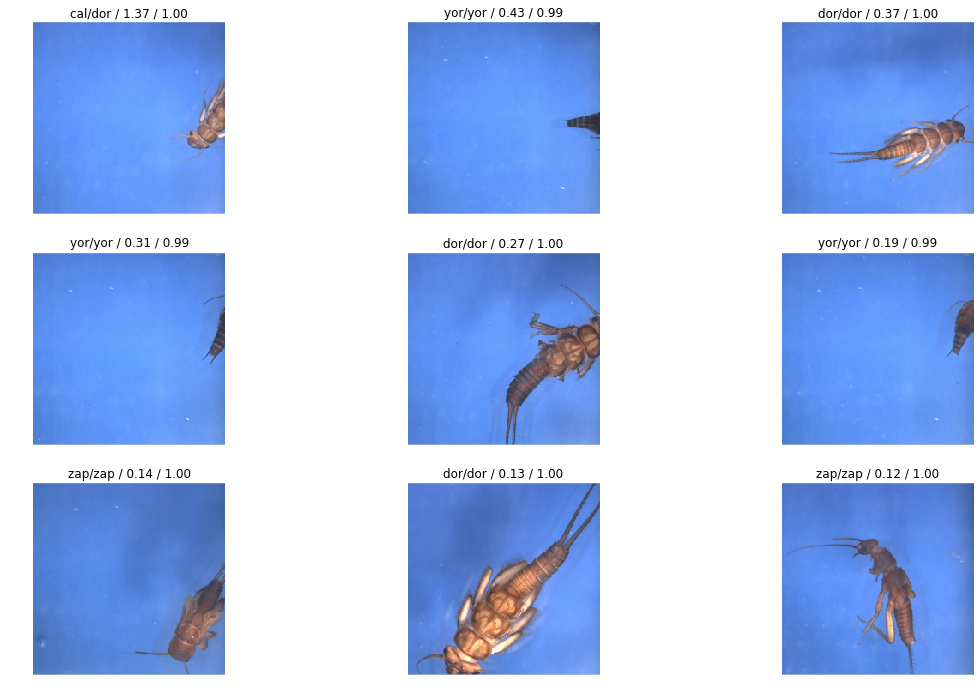

In [32]:
# show images with top_losses including their prediction, actual, loss, and probability of actual class
interp.plot_top_losses(9, figsize=(19,12))

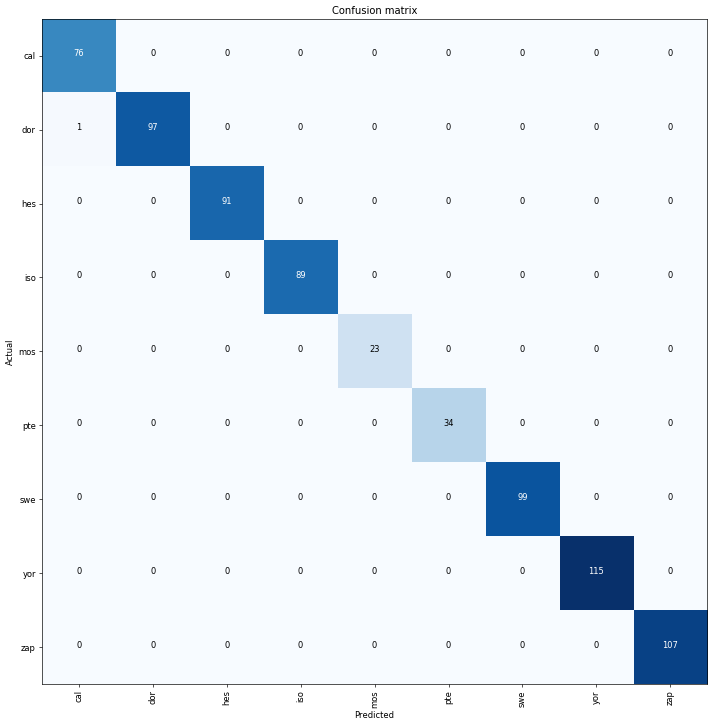

In [34]:
interp.plot_confusion_matrix(figsize=(17,12), dpi=60)

In [37]:
interp.most_confused() # (min_val=2)

[]

### Stage 2 - Training

In [18]:
learn.load('stonefly_resnet50_stage_1')

In [19]:
!gpustat

psbtmxtmo  Sat Oct 27 01:43:50 2018
[0] Quadro P4000     | 44'C,   0 % |   693 /  8119 MB | paperspace(683M)


In [20]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


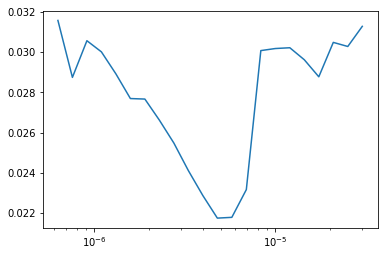

In [21]:
learn.recorder.plot()

In [22]:
lr=1e-6

In [23]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(1, max_lr=lr)

Total time: 00:48
epoch  train_loss  valid_loss  accuracy
1      0.029090    0.010917    0.998677  (00:48)



In [26]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 02:11
epoch  train_loss  valid_loss  accuracy
1      0.042720    0.009290    0.998677  (00:43)
2      0.034914    0.010522    0.998677  (00:44)
3      0.031330    0.009583    0.998677  (00:43)



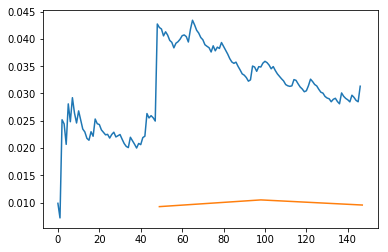

In [28]:
learn.recorder.plot_losses()

In [29]:
learn.fit_one_cycle(9, max_lr=lr)

Total time: 06:35
epoch  train_loss  valid_loss  accuracy
1      0.026035    0.010808    0.998677  (00:44)
2      0.031239    0.008893    0.998677  (00:42)
3      0.041115    0.009347    0.998677  (00:44)
4      0.027926    0.009095    0.998677  (00:46)
5      0.023413    0.008952    0.998677  (00:43)
6      0.036717    0.007138    0.998677  (00:43)
7      0.031984    0.008898    0.998677  (00:43)
8      0.028476    0.007304    0.998677  (00:44)
9      0.024679    0.008998    0.998677  (00:44)



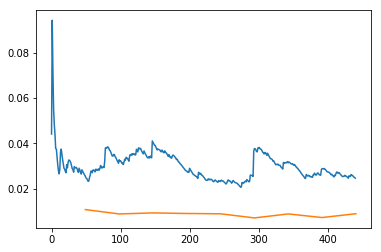

In [30]:
learn.recorder.plot_losses()

In [31]:
learn.save('stonefly_resnet50_stage_2')

### Stage 2 - Interpretation

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

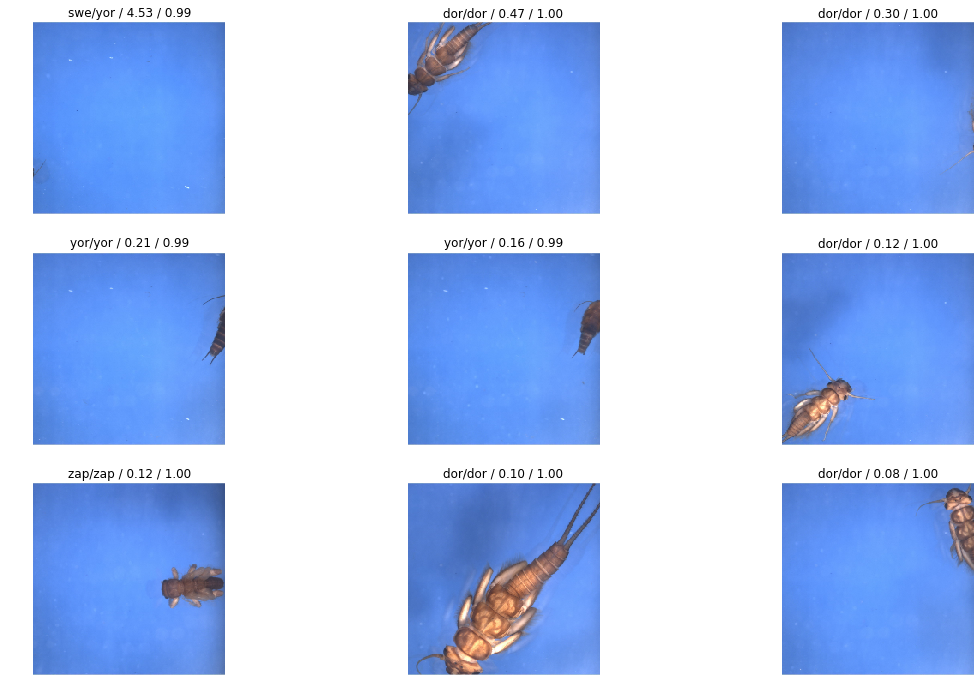

In [36]:
# show images with top_losses including their prediction, actual, loss, and probability of actual class
interp.plot_top_losses(9, figsize=(19,12))

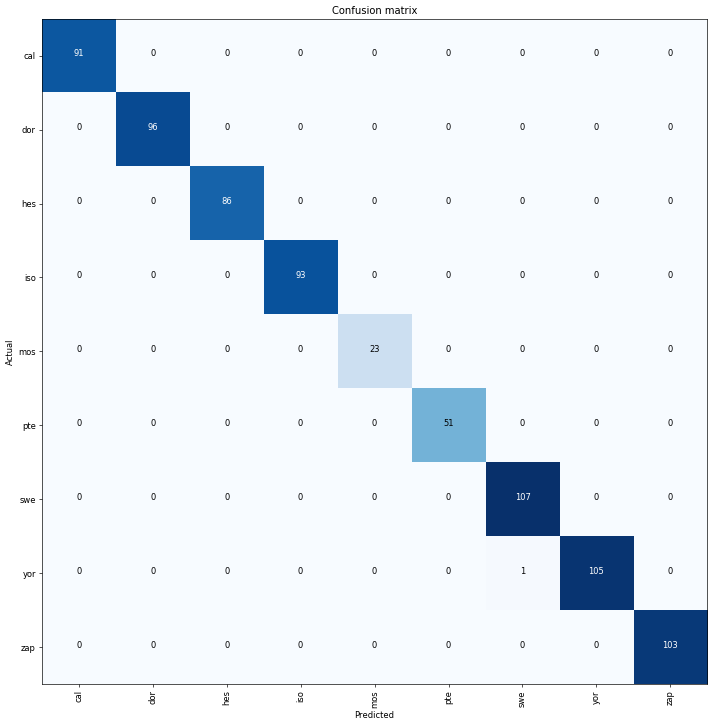

In [37]:
interp.plot_confusion_matrix(figsize=(17,12), dpi=60)

In [38]:
interp.most_confused(min_val=2)

[]

## In deep interpretation (coming soon)